In [ ]:
!pip install diffusers transformers torch torchvision matplotlib



In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return np.linspace(beta_start, beta_end, timesteps)


In [3]:
def get_alpha_values(beta):
    alphas = 1.0 - beta
    alphas_cumprod = np.cumprod(alphas)
    return alphas, alphas_cumprod


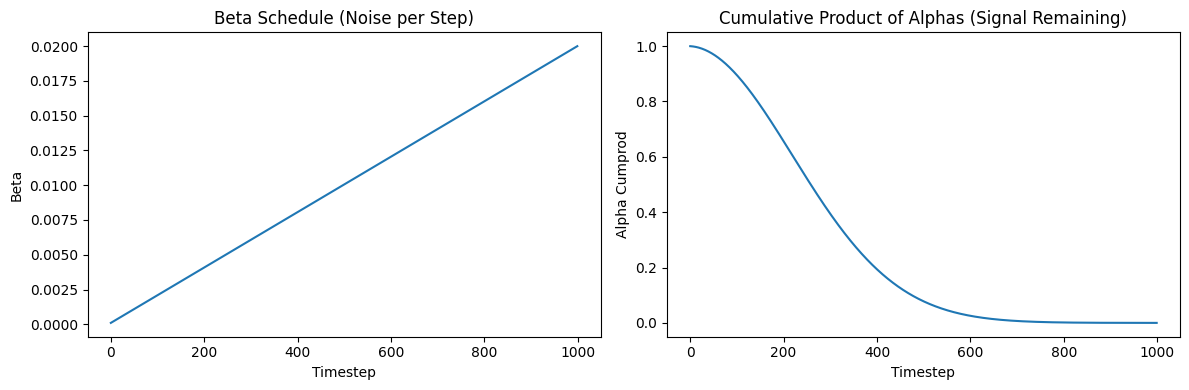

In [4]:
timesteps = 1000
beta = linear_beta_schedule(timesteps)
alphas, alphas_cumprod = get_alpha_values(beta)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(beta)
plt.title("Beta Schedule (Noise per Step)")
plt.xlabel("Timestep")
plt.ylabel("Beta")

plt.subplot(1, 2, 2)
plt.plot(alphas_cumprod)
plt.title("Cumulative Product of Alphas (Signal Remaining)")
plt.xlabel("Timestep")
plt.ylabel("Alpha Cumprod")

plt.tight_layout()
plt.show()


In [5]:
def forward_diffusion_sample(x0, t, alphas_cumprod):
    noise = np.random.randn(*x0.shape)
    alpha_t = alphas_cumprod[t]
    return np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise, noise


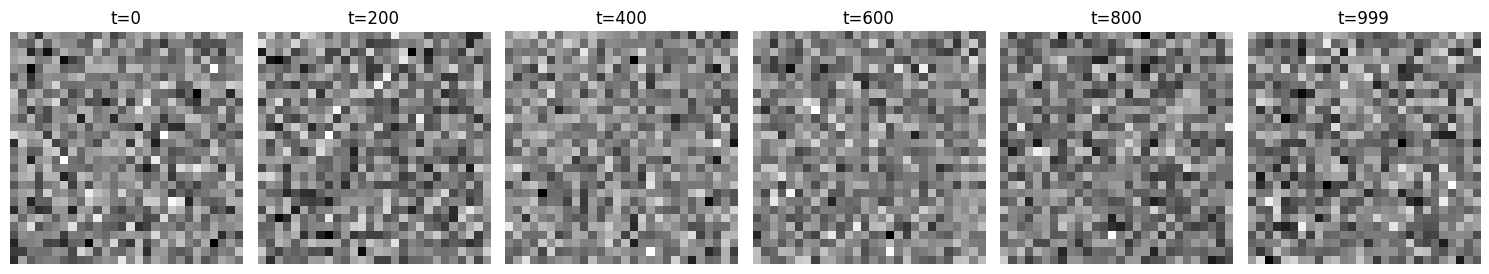

In [6]:
x0 = np.ones((28, 28))  # A simple white square
timesteps_to_view = [0, 200, 400, 600, 800, 999]

plt.figure(figsize=(15, 3))
for i, t in enumerate(timesteps_to_view):
    xt, _ = forward_diffusion_sample(x0, t, alphas_cumprod)
    plt.subplot(1, len(timesteps_to_view), i + 1)
    plt.imshow(xt, cmap='gray')
    plt.title(f"t={t}")
    plt.axis("off")

plt.tight_layout()
plt.show()


#  Load the Pipeline    

We're loading the Stable Diffusion model.

We don't need the text encoder or U-Net for now — just the scheduler (to apply noise) and vae (to work in latent space).

This is the same VAE and scheduler used during generation.

In [7]:
from diffusers import StableDiffusionPipeline


# Load the pipeline (just the scheduler & VAE for now)
pipe = StableDiffusionPipeline.from_pretrained("/opt/models/base-models/dreamshaper_v4")
pipe.to("cuda")
scheduler = pipe.scheduler
vae = pipe.vae




/home/albert/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
2025-04-19 00:12:22.519285: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 00:12:22.543452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 00:12:22.964939: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/ho

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/albert/miniconda3/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# Load and Encode a Real Image

The VAE works in a normalized [-1, 1] space.

The image must be resized to 512x512 (expected input).

We convert it into a tensor and move it to GPU.

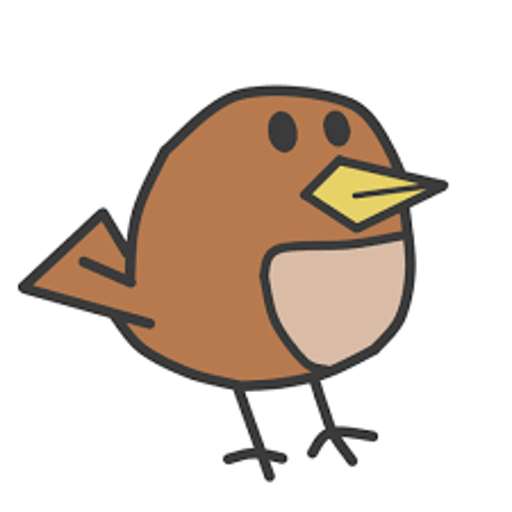

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch

image = Image.open("images.png").convert("RGB").resize((512, 512))

# Convert image to latent using the VAE
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
])
image_tensor = preprocess(image).unsqueeze(0).to("cuda")  # shape: [1, 3, 512, 512]

# Encode to latent
latents = vae.encode(image_tensor * 0.18215).latent_dist.sample()  # scale = 0.18215 (as used in SD)
latents = latents * 0.18215
image

We encode the image into a latent vector using the VAE.

The factor 0.18215 is a scaling factor used in Stable Diffusion to match the latent distribution learned during training.

# Simulate Adding Noise at Various Timesteps

This simulates what the forward diffusion process does during training.

The scheduler handles the math behind how much noise to add at each timestep.

In [9]:
def add_noise(latents, noise, timesteps, scheduler):
    return scheduler.add_noise(latents, noise, timesteps)

# Choose timesteps
timesteps_to_plot = [0, 50, 200, 400, 600, 999]
noise = torch.randn_like(latents)
noised_latents = [add_noise(latents, noise, torch.tensor([t], device="cuda"), scheduler) for t in timesteps_to_plot]

We pick a few timesteps (t=0 to t=999) to show the progression.

Add noise to the latent image at each of these steps using the scheduler's beta schedule.

The latents themselves are not images.

We must decode them using the VAE decoder to see what the model sees at each timestep.

In [10]:
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        images = vae.decode(latents).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    return images.cpu().permute(0, 2, 3, 1).numpy()

decoded_images = [decode_latents(latent)[0] for latent in noised_latents]


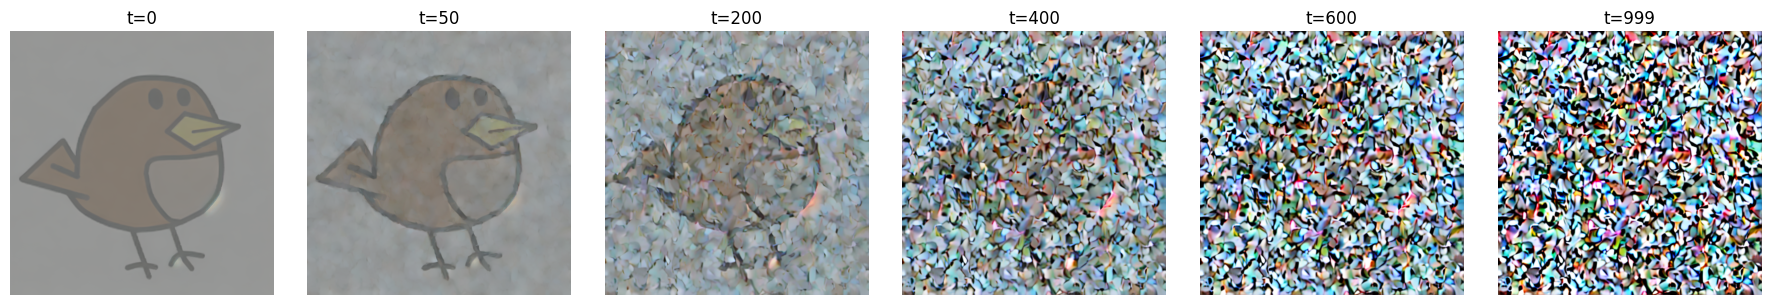

In [11]:
plt.figure(figsize=(18, 3))
for i, img in enumerate(decoded_images):
    plt.subplot(1, len(decoded_images), i+1)
    plt.imshow(img)
    plt.title(f"t={timesteps_to_plot[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


A series of images from t=0 to t=999.

The image becomes more and more noisy — simulating how the model gets trained to denoise this step-by-step.

In [ ]:
from diffusers import (
    DDIMScheduler,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
    AutoencoderKL
)
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import numpy as np

# Use the same pre-trained VAE for encoding/decoding
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")
vae = pipe.vae



In [21]:
from diffusers import DDIMScheduler, EulerDiscreteScheduler, DDPMScheduler

schedulers = {
    "DDIM": DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler"),
    "Euler": EulerDiscreteScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler"),
    "DDPM": DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
}


In [19]:
image = Image.open("images.png").convert("RGB").resize((512, 512))
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])
image_tensor = preprocess(image).unsqueeze(0).to("cuda")
latents = vae.encode(image_tensor * 0.18215).latent_dist.sample()
latents = latents * 0.18215


In [22]:
def add_noise(scheduler, latents, timesteps, noise):
    return scheduler.add_noise(latents, noise, timesteps)

timesteps_to_plot = [0, 50, 200, 400, 600, 999]
noise = torch.randn_like(latents)

results = {}

for name, scheduler in schedulers.items():
    noised_latents = []
    for t in timesteps_to_plot:
        t_tensor = torch.tensor([t], device="cuda")
        latent_t = add_noise(scheduler, latents, t_tensor, noise)
        noised_latents.append(latent_t)
    results[name] = noised_latents


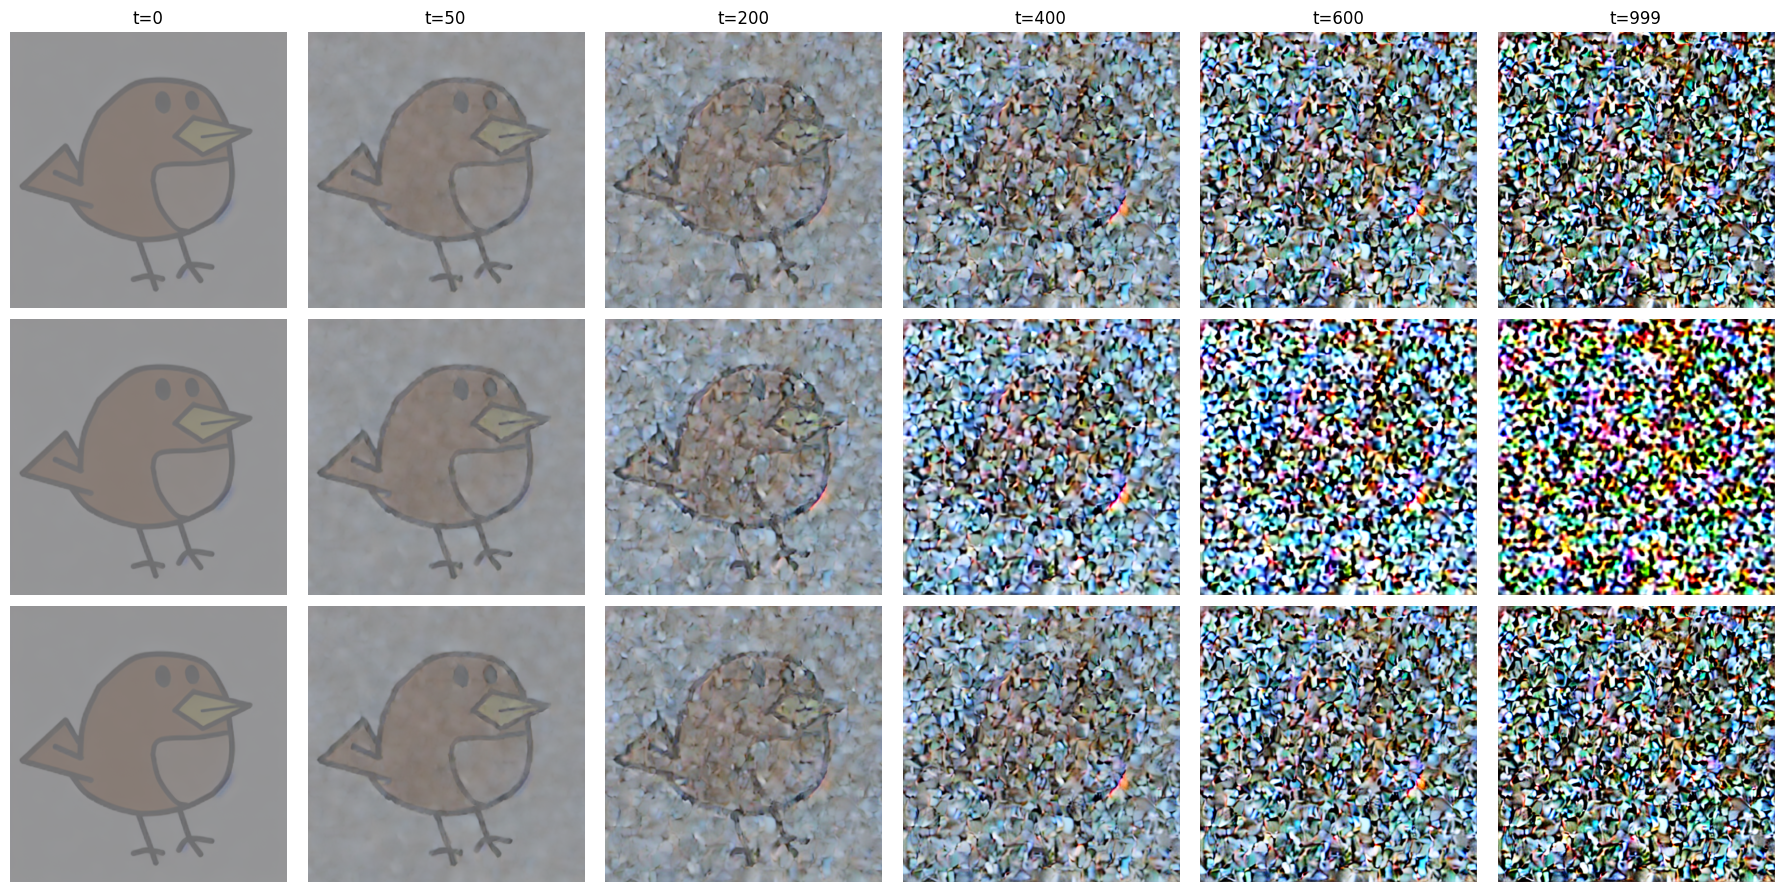

In [23]:
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        images = vae.decode(latents).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    return images.cpu().permute(0, 2, 3, 1).numpy()

fig, axs = plt.subplots(len(schedulers), len(timesteps_to_plot), figsize=(18, 9))

for i, (name, latents_list) in enumerate(results.items()):
    for j, latent in enumerate(latents_list):
        decoded = decode_latents(latent)[0]
        axs[i, j].imshow(decoded)
        if i == 0:
            axs[i, j].set_title(f"t={timesteps_to_plot[j]}")
        axs[i, j].axis("off")
    axs[i, 0].set_ylabel(name, fontsize=14)

plt.tight_layout()
plt.show()


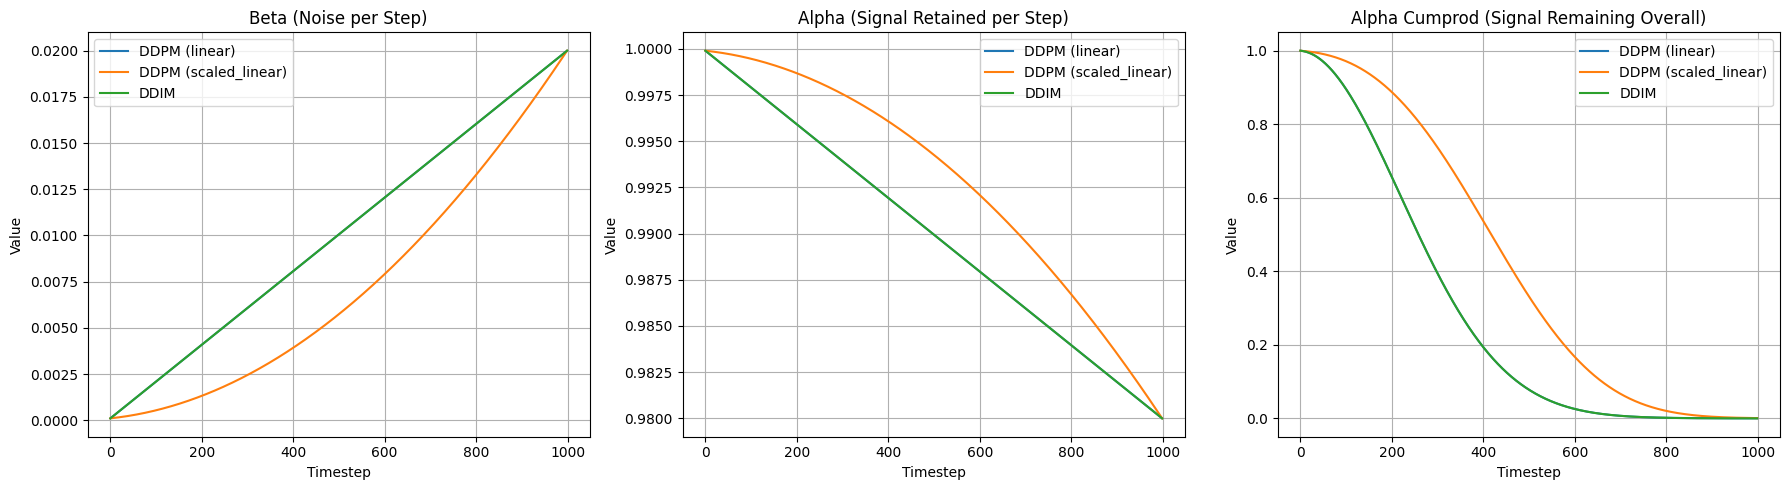

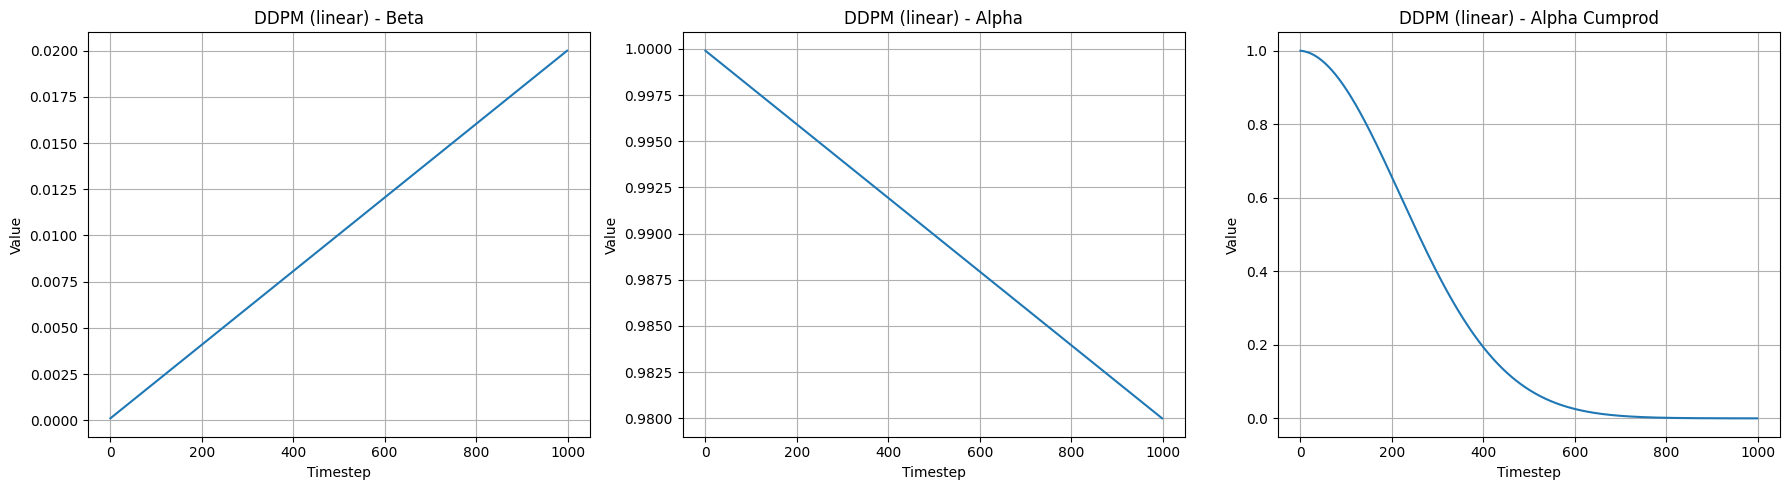

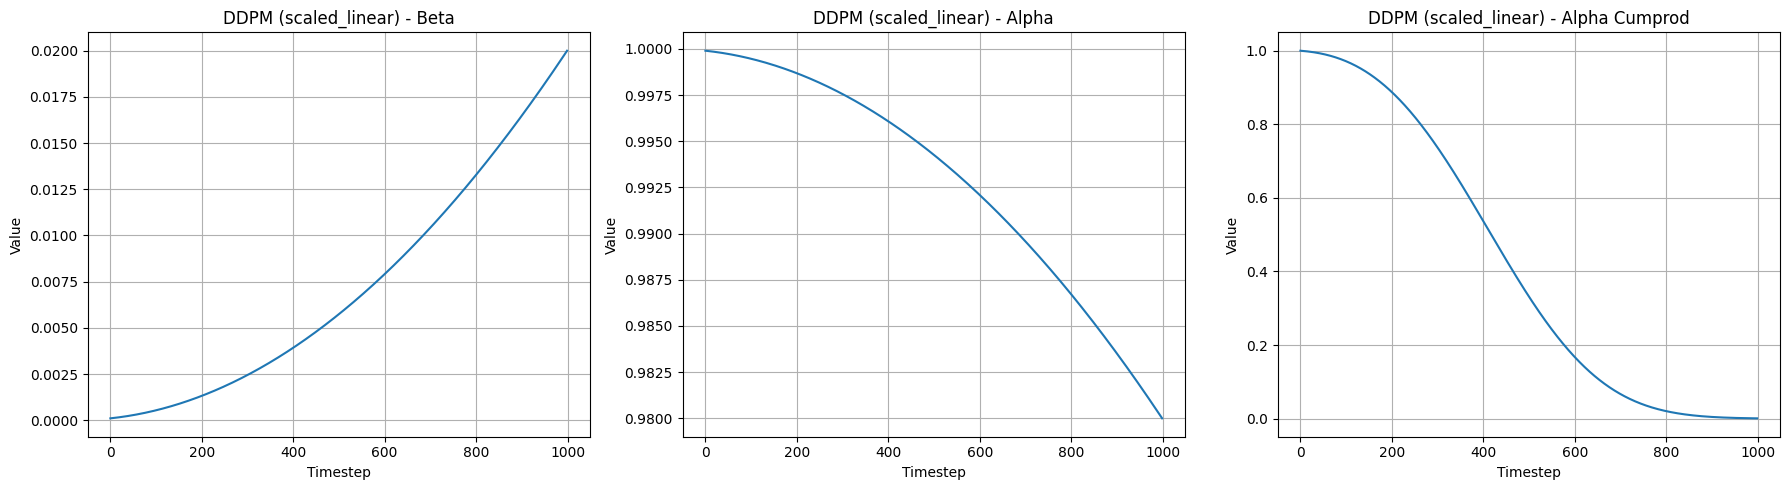

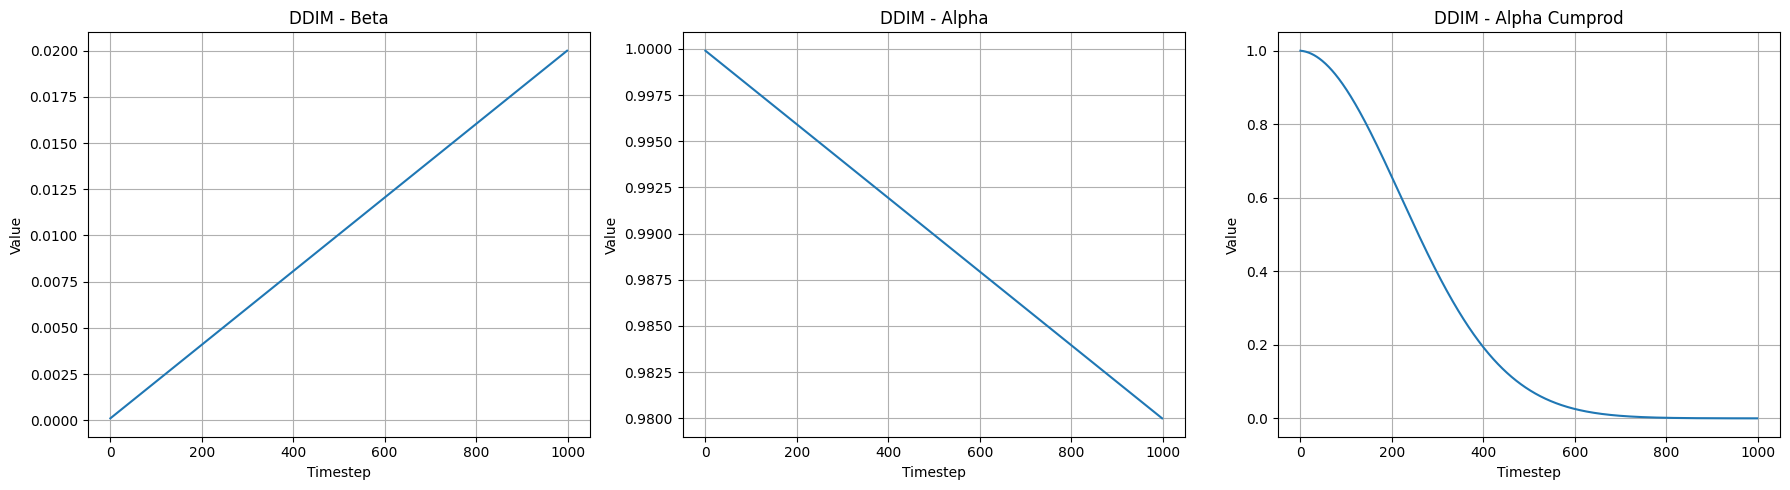

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMScheduler, DDIMScheduler

# Define different schedulers manually
schedulers = {
    "DDPM (linear)": DDPMScheduler(
        num_train_timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        beta_schedule="linear"
    ),
    "DDPM (scaled_linear)": DDPMScheduler(
        num_train_timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        beta_schedule="scaled_linear"
    ),
    "DDIM": DDIMScheduler(
        num_train_timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        beta_schedule="linear"
    )
}

timesteps = np.arange(1000)
plot_data = {}

# Collect beta, alpha, and alpha_cumprod values
for name, scheduler in schedulers.items():
    scheduler.set_timesteps(1000)
    betas = scheduler.betas[:1000]
    alphas = 1.0 - betas
    alphas_cumprod = np.cumprod(alphas)
    plot_data[name] = {
        "betas": betas,
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod
    }

# --- Merged Plot ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for name, data in plot_data.items():
    axs[0].plot(timesteps, data["betas"], label=name)
    axs[1].plot(timesteps, data["alphas"], label=name)
    axs[2].plot(timesteps, data["alphas_cumprod"], label=name)

axs[0].set_title("Beta (Noise per Step)")
axs[1].set_title("Alpha (Signal Retained per Step)")
axs[2].set_title("Alpha Cumprod (Signal Remaining Overall)")

for ax in axs:
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- Individual Plots ---
for name, data in plot_data.items():
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    axs[0].plot(timesteps, data["betas"])
    axs[0].set_title(f"{name} - Beta")

    axs[1].plot(timesteps, data["alphas"])
    axs[1].set_title(f"{name} - Alpha")

    axs[2].plot(timesteps, data["alphas_cumprod"])
    axs[2].set_title(f"{name} - Alpha Cumprod")

    for ax in axs:
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Value")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


In [38]:
from diffusers.schedulers.scheduling_utils import SchedulerMixin
from diffusers.configuration_utils import ConfigMixin

class MyCustomScheduler(SchedulerMixin, ConfigMixin):
    def __init__(self, num_train_timesteps=1000):
        self.num_train_timesteps = num_train_timesteps
        self.betas = self._custom_beta_schedule()
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.init_noise_sigma = 1.0  # required by diffusers

    def _custom_beta_schedule(self):
        """
        Define your own beta schedule.
        This example: cosine-shaped noise schedule.
        """
        steps = torch.arange(self.num_train_timesteps, dtype=torch.float32)
        betas = 0.01 * torch.cos((steps / self.num_train_timesteps) * 3.14159 / 2) ** 2
        return betas.clamp(1e-8, 0.999)

    def add_noise(self, original_samples, noise, timesteps):
        """
        Forward process: x_t = sqrt(a_t) * x_0 + sqrt(1 - a_t) * noise
        """
        device = original_samples.device
        alphas_cumprod = self.alphas_cumprod.to(device)

        sqrt_alpha_prod = alphas_cumprod[timesteps] ** 0.5
        sqrt_one_minus_alpha_prod = (1 - alphas_cumprod[timesteps]) ** 0.5

        # Ensure correct broadcasting over image shape
        while sqrt_alpha_prod.ndim < original_samples.ndim:
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        return sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise


    def set_timesteps(self, num_inference_steps):
        """
        Required for compatibility with diffusers pipeline.
        """
        self.timesteps = torch.linspace(0, self.num_train_timesteps - 1, num_inference_steps).long()


In [ ]:

scheduler = MyCustomScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(50)

print("betas:", scheduler.betas[:5])
print("alphas:", scheduler.alphas[:5])
print("alphas_cumprod:", scheduler.alphas_cumprod[:5])

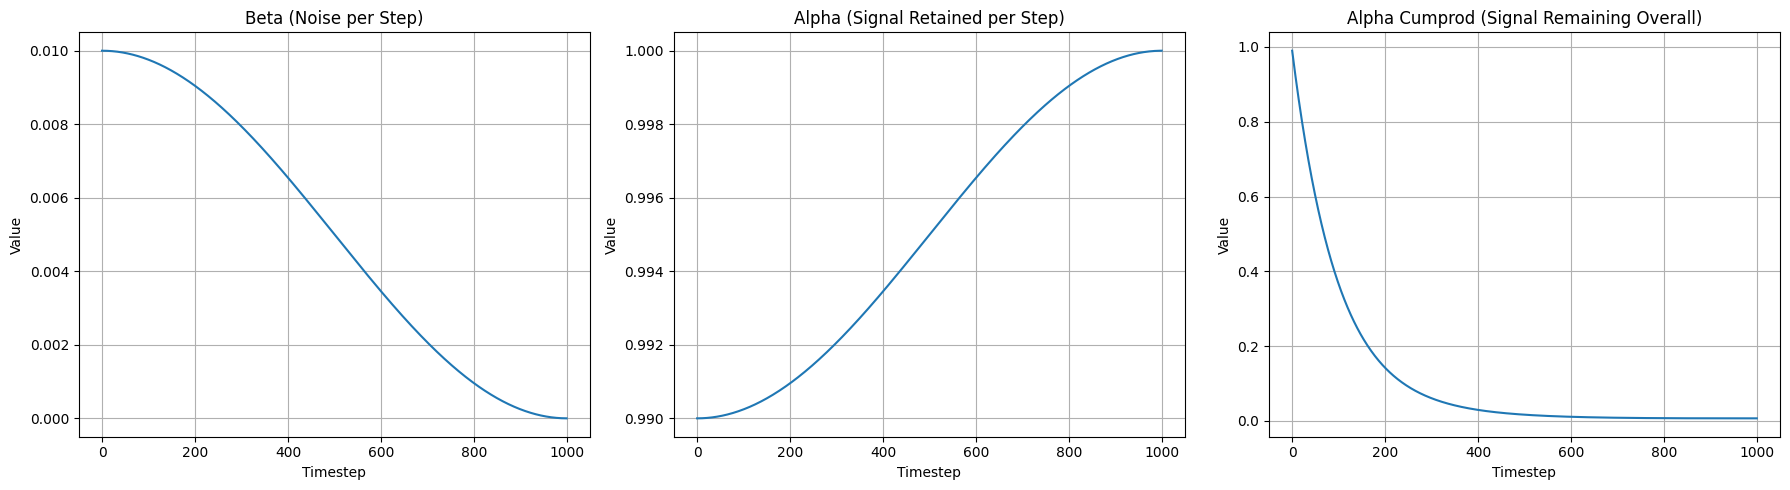

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize your custom scheduler
scheduler = MyCustomScheduler(num_train_timesteps=1000)
timesteps = np.arange(1000)

betas = scheduler.betas.cpu().numpy()
alphas = scheduler.alphas.cpu().numpy()
alphas_cumprod = scheduler.alphas_cumprod.cpu().numpy()

# Plot each curve
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(timesteps, betas, label='Beta')
axs[0].set_title("Beta (Noise per Step)")
axs[1].plot(timesteps, alphas, label='Alpha')
axs[1].set_title("Alpha (Signal Retained per Step)")
axs[2].plot(timesteps, alphas_cumprod, label='Alpha Cumprod')
axs[2].set_title("Alpha Cumprod (Signal Remaining Overall)")

for ax in axs:
    ax.set_xlabel("Timestep")
    ax.set_ylabel("Value")
    ax.grid(True)

plt.tight_layout()
plt.show()


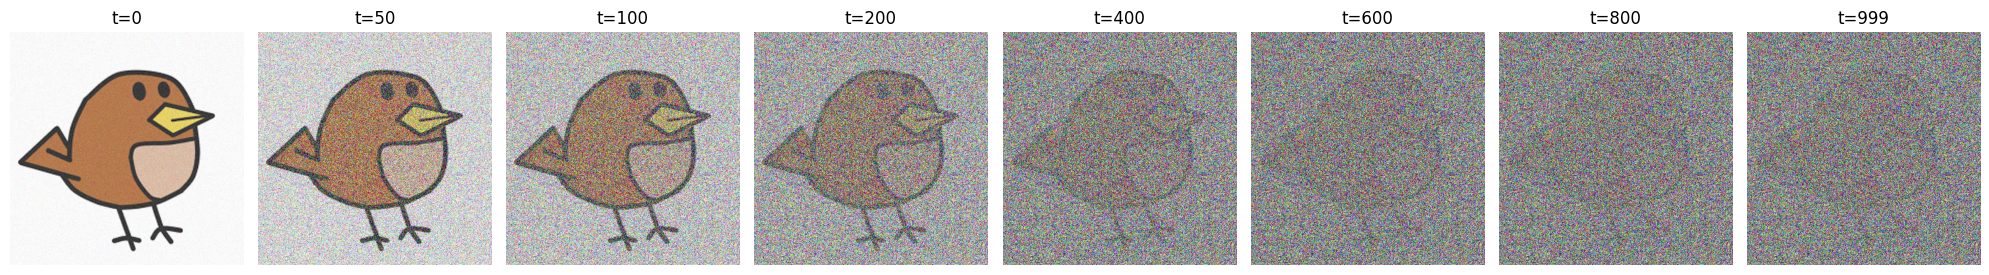

In [39]:
import torch
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# Load and preprocess image
image_path = "images.png"  # replace with your own image
image = Image.open(image_path).convert("RGB").resize((512, 512))

transform = T.Compose([
    T.ToTensor(),                 # HWC -> CHW
    T.Normalize([0.5], [0.5])     # Scale to [-1, 1]
])
image_tensor = transform(image).unsqueeze(0).to("cuda")  # shape: [1, 3, 512, 512]

# Encode to latent (simulate this if you don't use VAE)
latents = image_tensor  # use image directly for simplicity (or use VAE.encode if using latent)

# Instantiate custom scheduler
scheduler = MyCustomScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(1000)

# Pick a fixed noise
noise = torch.randn_like(latents)

# Visualize different steps
timesteps_to_plot = [0, 50, 100, 200, 400, 600, 800, 999]
fig, axs = plt.subplots(1, len(timesteps_to_plot), figsize=(20, 3))

for i, t in enumerate(timesteps_to_plot):
    t_tensor = torch.tensor([t], device="cuda")
    noised = scheduler.add_noise(latents, noise, t_tensor).detach()

    # Denormalize to [0, 1]
    image_vis = noised[0].cpu() * 0.5 + 0.5
    axs[i].imshow(image_vis.permute(1, 2, 0).clamp(0, 1).numpy())
    axs[i].set_title(f"t={t}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()
